In [1]:
import os
import os.path as osp
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, IterableDataset
import random
import math
import string
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import collections
import itertools
from sklearn.manifold import TSNE
from nltk import tokenize, sent_tokenize

nltk.data.path.append(os.path.join(os.path.expanduser('~'), '.nltk_data'))
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mtb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
dataset_path = os.getenv("DL_DATASET")

In [3]:
embedding_dataset_path =[osp.join(dataset_path, 
                                  f"OANC_GrAF/OANC-GrAF/data/written_1/journal/slate/{i}") 
                                  for i in range(1, 50)
                ]               

<h1> Load Data </h1>

In [4]:
files = []

for folder in embedding_dataset_path:
    for file_index in os.listdir(folder):
        if not file_index.endswith(".txt"):
            continue
        files.append(osp.join(folder, file_index))

In [5]:
len(files)

3591

In [6]:
files = sorted(files)

In [7]:
files[0]

'/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/data/written_1/journal/slate/1/Article247_4.txt'

In [8]:
def read_file(filename):
    with open(filename, mode='r', encoding='utf-8') as f:
        return f.read()


In [9]:
read_file(files[0])

'\n   \n   \n      \n         \n            Harmonic Convergences\n            \n\n            You\'re right, Maxim\'s strong point is that it\'s totally unsentimental\nand ungenteel. It\'s a sendup of the old model, but in a different way than,\nsay, Hustler was, and the difference (surprise) reflects the sexual\nculture of the \'90s. With its belligerent grossness and misogyny,\nHustler rebelled against the establishment men\'s mags\' class\ncondescension, the earnest philosophizing about the sexual revolution, the\n"thinking men\'s sex bomb" syndrome, at the same time that it was deliberately\ngoading feminists. It came right out with the anger that the regular men\'s mags\ntried to hide. Maxim pokes fun at its progenitors but with considerable\nironic affection. It\'s not angry. In fact, while its fondness for the most\nidiotic, juvenile humor knows no bounds, any strong emotion is taboo (unless\nyou count horror at having your penis mangled)--that\'s part of the British\ninfluence

In [10]:
df_filenames, df_texts, df_paths = [], [], []

for filename in files:
    df_paths.append(filename)
    df_filenames.append(os.path.basename(filename))
    df_texts.append(read_file(filename))
ndf = pd.DataFrame({'path': df_paths,
                   'filename': df_filenames,
                   'text_raw': df_texts,
                   })
ndf


,path,filename,text_raw
0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...
1,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_40.txt,\n \n \n \n \n All...
2,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_42.txt,\n \n \n \n \n Pic...
3,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_47.txt,\n \n \n \n \n The...
4,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_5.txt,\n \n \n \n \n Bad...
...,...,...,...
3586,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3295.txt,\n \n \n \n \n Wea...
3587,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3296.txt,\n \n \n \n \n ER:...
3588,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3297.txt,\n \n \n \n \n Is ...
3589,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3298.txt,\n \n \n \n \n No ...


In [11]:
sent_tokenize(ndf['text_raw'][0])

["\n   \n   \n      \n         \n            Harmonic Convergences\n            \n\n            You're right, Maxim's strong point is that it's totally unsentimental\nand ungenteel.",
 "It's a sendup of the old model, but in a different way than,\nsay, Hustler was, and the difference (surprise) reflects the sexual\nculture of the '90s.",
 'With its belligerent grossness and misogyny,\nHustler rebelled against the establishment men\'s mags\' class\ncondescension, the earnest philosophizing about the sexual revolution, the\n"thinking men\'s sex bomb" syndrome, at the same time that it was deliberately\ngoading feminists.',
 "It came right out with the anger that the regular men's mags\ntried to hide.",
 'Maxim pokes fun at its progenitors but with considerable\nironic affection.',
 "It's not angry.",
 "In fact, while its fondness for the most\nidiotic, juvenile humor knows no bounds, any strong emotion is taboo (unless\nyou count horror at having your penis mangled)--that's part of the B

In [12]:
df = []
for i in range(len(ndf)):
    tokenize_sent = sent_tokenize(ndf['text_raw'][i])
    _df = ndf.iloc[i: i+1,].copy(deep=True)
    _df = pd.concat([_df.copy(deep=True) for _  in range(len(tokenize_sent))]).reset_index()
    _df['text'] = tokenize_sent 
    df.append(_df)
df = pd.concat(df).reset_index()

In [13]:
df

,level_0,index,path,filename,text_raw,text
0,0,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,\n \n \n \n \n Har...
1,1,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,"It's a sendup of the old model, but in a diffe..."
2,2,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,"With its belligerent grossness and misogyny,\n..."
3,3,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,It came right out with the anger that the regu...
4,4,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,Maxim pokes fun at its progenitors but with co...
...,...,...,...,...,...,...
161507,28,3590,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,"I never quite figured out, for\nexample, what ..."
161508,29,3590,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,"Poor Hick, bereft of career, living in\na perp..."
161509,30,3590,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,"Marjorie, it's been a delight to correspond wi..."
161510,31,3590,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,Best wishes\nuntil we meet again--perhaps over...


<h1> Preprocess DATA </h1>

In [14]:
text = np.stack(df['text'].values)

In [15]:
text

array(["\n   \n   \n      \n         \n            Harmonic Convergences\n            \n\n            You're right, Maxim's strong point is that it's totally unsentimental\nand ungenteel.",
       "It's a sendup of the old model, but in a different way than,\nsay, Hustler was, and the difference (surprise) reflects the sexual\nculture of the '90s.",
       'With its belligerent grossness and misogyny,\nHustler rebelled against the establishment men\'s mags\' class\ncondescension, the earnest philosophizing about the sexual revolution, the\n"thinking men\'s sex bomb" syndrome, at the same time that it was deliberately\ngoading feminists.',
       ...,
       "Marjorie, it's been a delight to correspond with you this week.",
       'Best wishes\nuntil we meet again--perhaps over Volume 9 of some future 14-volume\nbiography of Rosalynn Carter.',
       'Yours,\n\n            Chris'], dtype='<U4371')

In [16]:
len(text)

161512

In [17]:
def preprocess_text(text):
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)
    text = text.translate(string.punctuation)
    
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\-\-", " ", text)
    text = re.sub(r"\-\s+\-", " ", text)
    text = re.sub(r"\s+\-\s+", "-", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text
    

df['text_preprocess'] = df['text'].apply(preprocess_text)

In [18]:
df['text_preprocess']

0         harmonic convergences you are right maxim stro...
1         it a sendup of the old model but in a differen...
2         with its belligerent grossness and misogyny hu...
3         it came right out with the anger that the regu...
4         maxim pokes fun at its progenitors but with co...
                                ...                        
161507    i never quite figured out for example what the...
161508    poor hick bereft of career living in a perpetu...
161509    marjorie it been a delight to correspond with ...
161510    best wishes until we meet again perhaps over v...
161511                                          yours chris
Name: text_preprocess, Length: 161512, dtype: object

In [19]:
# for i in range(len(df['text_preprocess'])):
#     sentence = df['text_preprocess'].iloc[i]
#     if '-' in sentence:
#         print(sentence)
    

In [20]:
corpus = df['text_preprocess'].tolist()

In [21]:
len(corpus)

161512

In [22]:
words = [tokenize.word_tokenize(x) for x in corpus]

In [23]:
words[0]

['harmonic',
 'convergences',
 'you',
 'are',
 'right',
 'maxim',
 'strong',
 'point',
 'is',
 'that',
 'it',
 'totally',
 'unsentimental',
 'and',
 'ungenteel']

In [24]:
counter = collections.Counter(np.concatenate(words))

In [25]:
counter['the']

207534

In [26]:
counter['and']


73401

In [27]:
voc_df = pd.DataFrame([counter]).T.reset_index()
voc_df.columns = ['words','count']
voc_df = voc_df.sort_values(by='count', ascending=False).reset_index(drop=True)

In [28]:
voc_df

,words,count
0,the,207534
1,of,89733
2,to,82077
3,a,77055
4,and,73401
...,...,...
81152,half-millennium,1
81153,data-creation,1
81154,applause-getters,1
81155,impartially,1


<AxesSubplot: xlabel='words'>

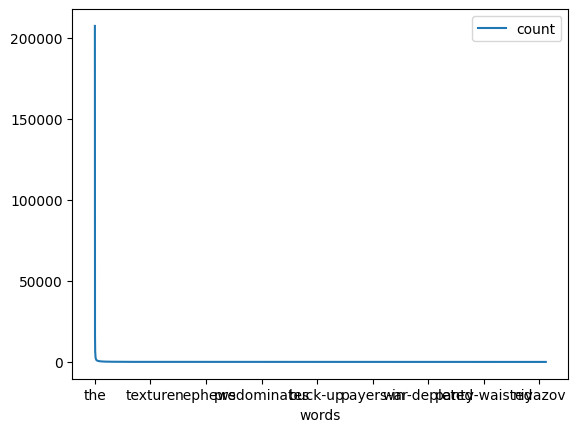

In [29]:
voc_df.sort_values(by='count', ascending=False).plot(x='words')

In [30]:
voc_df

,words,count
0,the,207534
1,of,89733
2,to,82077
3,a,77055
4,and,73401
...,...,...
81152,half-millennium,1
81153,data-creation,1
81154,applause-getters,1
81155,impartially,1


In [31]:
voc_df.to_csv('./data.csv')

<h1> Model DATA processing </h1>

In [32]:
class Vocabulary:
    SPECIAL_CHARS =['<unk>']
    def __init__(self, corpus, min_freq=None, special_chars="unk") -> None:
        self.corpus = corpus
        self.special_chars = special_chars
        self.sentences = [tokenize.word_tokenize(sentence)
                                            for sentence in corpus]
        self.counter = collections.Counter(np.concatenate(self.sentences))
        self.voc_df = self.get_vocab_df(self.counter)
        self.min_freq = min_freq 
        
        self.token_dict = {}       
        self.idx_dict = {}       
    
    def __getitem__(self, index):
        pass
    
    def __len__(self):
        return len(self.voc_df)

    def get_vocab_df(self, counter):
        voc_df = pd.DataFrame([counter]).T.reset_index()
        voc_df.columns = ['token','count']
        voc_df = voc_df.sort_values(by='count', ascending=False).reset_index(drop=True)
        
        return voc_df

    def preprocess(self):
        condition = self.voc_df['count'] >= self.min_freq
        unk_count = self.voc_df.loc[~condition, "count"].sum()
        trunc_voc_df = self.voc_df[condition].copy().reset_index(drop=True)
        
        self.trunc_voc_df = trunc_voc_df
        
        trunc_voc_df.loc[:, 'idx'] = trunc_voc_df.index + 1
        
        trunc_voc_df = pd.concat([trunc_voc_df,
                                  pd.DataFrame({"idx": [0], 
                                                 "token": [self.special_chars],
                                                 "count": [unk_count]
                                                 }
                                               )
                                  ]).reset_index(drop=True)
        
        self.counter = dict(zip(trunc_voc_df ['token'], trunc_voc_df['count']))
        
        
        self.token_dict = dict(zip(trunc_voc_df['token'],
                                  trunc_voc_df['idx'],
                                  ))    
        self.idx_dict = dict(zip(trunc_voc_df['idx'],
                                  trunc_voc_df['token'],
                                  ))        
        self.voc_df = trunc_voc_df
        
        self.sentences = [[token if token in self.token_dict else self.special_chars 
                           for token in tokens] 
                          for tokens in self.sentences]
        
    def get_token(self, index):
        return self.tokens[index]
    
    def idx_to_token(self, idx):
        return [self.idx_dict[id] for id in idx]
    
    def token_to_idx(self, tokens):
        return [self.token_dict[token] if token in self.token_dict else -1 
                for token in tokens]
        
        


In [33]:
vocab = Vocabulary(corpus, min_freq=5)

In [34]:
vocab.voc_df

,token,count
0,the,207534
1,of,89733
2,to,82077
3,a,77055
4,and,73401
...,...,...
81152,half-millennium,1
81153,data-creation,1
81154,applause-getters,1
81155,impartially,1


In [35]:
vocab.voc_df['count'].sum()

3286170

In [36]:
vocab.preprocess()

In [37]:
vocab.voc_df

,token,count,idx
0,the,207534,1
1,of,89733,2
2,to,82077,3
3,a,77055,4
4,and,73401,5
...,...,...,...
28007,darrow,5,28008
28008,annotated,5,28009
28009,rustic,5,28010
28010,afflicting,5,28011


In [38]:
vocab.voc_df['count'].sum()

3286170

In [39]:
vocab.sentences[0], corpus[0]

(['unk',
  'unk',
  'you',
  'are',
  'right',
  'maxim',
  'strong',
  'point',
  'is',
  'that',
  'it',
  'totally',
  'unsentimental',
  'and',
  'unk'],
 'harmonic convergences you are right maxim strong point is that it totally unsentimental and ungenteel ')

In [40]:
class NegativeSampling:
    
    def __init__(self, weights) -> None:
        self.weights = weights
        self.population = list(range(1, len(self.weights) + 1))
        self.candidate = []
        self.i = 0
    def sample(self):
        if self.i == len(self.candidate):
            self.candidate = random.choices(self.population, self.weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidate[self.i - 1]
        
        

In [41]:
def extract_contexts_and_center(sentences, counter, unk_char="unk", max_window_size=5):
    centers, contexts = [], []
    num_tokens = sum(counter.values())
    for tokens in sentences:
        if len(tokens) < 2:
            continue
        for i in range(len(tokens)):
            token = tokens[i]
            if token == unk_char or random.uniform(0, 1) < (1e-4 / counter[token] * num_tokens ):
                continue
            window_size = random.randint(1, max_window_size)
            low, high = max(0, i - window_size), min(i + 1 + window_size, len(tokens))
            indices = list(range(low, i)) + list(range(i+1, high))
            values = [tokens[idx] for idx in indices if tokens[idx] != unk_char]
            if values:
                contexts.append(values)
                centers.append(token)
        
    return centers, contexts

In [42]:
vocab = Vocabulary(corpus, min_freq=5)
vocab.preprocess()

In [43]:
centers, contexts = extract_contexts_and_center(vocab.sentences[-2:], counter)


In [44]:
random.uniform(0, 1)

0.8455868049738062

In [45]:
centers, contexts

(['best',
  'until',
  'we',
  'again',
  'perhaps',
  'over',
  'of',
  'some',
  'future',
  'of'],
 [['wishes'],
  ['best', 'wishes', 'we', 'meet'],
  ['until', 'meet'],
  ['we', 'meet', 'perhaps', 'over'],
  ['wishes',
   'until',
   'we',
   'meet',
   'again',
   'over',
   'volume',
   '9',
   'of',
   'some'],
  ['we', 'meet', 'again', 'perhaps', 'volume', '9', 'of', 'some'],
  ['over', 'volume', '9', 'some', 'future'],
  ['over', 'volume', '9', 'of', 'future', 'biography', 'of'],
  ['volume', '9', 'of', 'some', 'biography', 'of'],
  ['of', 'some', 'future', 'biography', 'carter']])

In [46]:
def get_negatives(contexts, vocab, k=5):  
    voc_df = vocab.voc_df[vocab.voc_df['token'] != "unk"].copy()
    voc_df['sampling_weights'] = voc_df['count'] ** 0.75
    generator = NegativeSampling(voc_df['sampling_weights'].tolist())
    contexts_negatives = []
    for context in contexts:
        context_negative = []
        while len(context_negative) < k:
            idx = generator.sample()
            token = vocab.idx_to_token([idx])[0]
            if token in context:
                continue
            context_negative.append(token)
        contexts_negatives.append(context_negative)
    
    return contexts_negatives
negatives = get_negatives(contexts, vocab)

In [47]:
def load_data(corpus):
    vocab = Vocabulary(corpus, min_freq=5)
    vocab.preprocess()
    centers, contexts = extract_contexts_and_center(vocab.sentences, vocab.counter)
    negatives = get_negatives(contexts, vocab)
    
    return vocab, centers, contexts, negatives
    

In [48]:
vocab, centers, contexts, negatives = load_data(corpus)
num_classes = len(vocab)

In [49]:
len(centers), len(contexts), len(negatives)

(1929177, 1929177, 1929177)

In [50]:
centers[0], contexts[0], negatives[0]

('you',
 ['are', 'right', 'maxim', 'strong', 'point'],
 ['fritz', 'york', 'like', 'television', 'saying'])

In [51]:
class OANCDataset(Dataset):
    
    def __init__(self, centers, contexts, negatives) -> None:
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives
    
    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)


In [52]:
def collate_fn(data):
    centers, contexts, masks, labels = [], [], [], []
    max_len = max(len(co) + len(neg) for ce, co, neg in data)
    for center, context, negative in data:
        centers.append(vocab.token_to_idx([center]))
        contexts.append([vocab.token_to_idx([c])[0] for c in context] + \
                        [vocab.token_to_idx([c])[0] for c in negative] + \
                        [0] * (max_len - len(context) - len(negative)))
        masks.append(
            [1] * (len(context) + len(negative)) + [0] * (max_len - len(context) - len(negative))
        )
        labels.append(
            [1] * len(context) + [0] * (max_len - len(context))
        )
    return (torch.tensor(centers, dtype=torch.int64),
            torch.tensor(contexts, dtype=torch.long),
            torch.tensor(masks, dtype=torch.long),
            torch.tensor(labels, dtype=torch.long)
    )
  

In [53]:
dataset = OANCDataset(centers, contexts, negatives)

In [54]:
len(dataset)

1929177

In [55]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [56]:
data = next(iter(dataloader))

In [57]:
data[1][:10], data[1].shape

(tensor([[   15,    19,    11,   558,    13,     2,     4,   566, 21488,    13,
             71,    76,  2698,   207,     3],
         [   11, 27905,  3642,  5830,   432,  1073, 24953,     0,     0,     0,
              0,     0,     0,     0,     0],
         [   33,     6, 14975, 16311,     1,   687,  2678,    19,     0,     0,
              0,     0,     0,     0,     0],
         [    3,   848,    60,    64,   587,     2, 11203, 12443,  6808,   325,
           5082,     0,     0,     0,     0],
         [  303,     1,   346,  8615,   563,   837,     3,   165,     6,   556,
            418,   101, 12988,     0,     0],
         [   42,    16,   815,     1, 13063,    28,  1624,  4012,   685,    14,
          17945,     0,     0,     0,     0],
         [   78,     1,  2433, 17563,   390,  2163,   105,   111,   153,     0,
              0,     0,     0,     0,     0],
         [13020,    60, 13716, 24424,  1715,  6143,   370,   462,     0,     0,
              0,     0,     0,     0, 

In [58]:
test_data = F.one_hot(data[1], num_classes)
test_data.shape

torch.Size([128, 15, 28012])

In [59]:
nn.Embedding(num_embeddings=num_classes,
             embedding_dim=300)(data[1]).shape


torch.Size([128, 15, 300])

In [60]:
data[0].shape

torch.Size([128, 1])

In [61]:
nn.Embedding(num_embeddings=num_classes,
             embedding_dim=300)(data[0]).shape

torch.Size([128, 1, 300])

In [62]:
class SkipGram(nn.Module):
    
    def __init__(self, num_classes, hidden_size=10) -> None:
        super().__init__()
        self.embed_v = nn.Embedding(num_classes, embedding_dim=hidden_size)
        self.embed_u = nn.Embedding(num_classes, embedding_dim=hidden_size)
        self.initialize()
    
    def initialize(self,):
        with torch.no_grad():
            nn.init.xavier_normal_(self.embed_u.weight)    
            nn.init.normal_(self.embed_v.weight)
    
    def forward(self, centers, contexts_and_negatives):
        v = self.embed_v(centers)
        u = self.embed_u(contexts_and_negatives)
        pred = torch.bmm(v, u.permute(0, 2, 1)).squeeze(dim=1)
        return pred


In [63]:
class BinaryLoss(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, input, target, mask=None):
        return F.binary_cross_entropy_with_logits(input, target, weight=mask, reduction="none").mean(dim=1)

In [64]:
device = torch.device('cuda')
net = SkipGram(num_classes, hidden_size=256).to(device=device)
loss_fn = BinaryLoss()

In [65]:
optimizer = torch.optim.Adam(params=net.parameters(),
                             lr=0.005
                             )
# optimizer = torch.optim.SGD(params=net.parameters(),
                            #  lr=0.01, momentum=0.9, nesterov=True
                            #  )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9998)
net.train()

SkipGram(
  (embed_v): Embedding(28012, 256)
  (embed_u): Embedding(28012, 256)
)

In [66]:
# net.load_state_dict(torch.load( "./cbow.pth")["model_state_dict"])
# optimizer.load_state_dict(torch.load( "./cbow.pth")["optimizer_state_dict"])

In [67]:
dataloader = DataLoader(dataset, batch_size=1024, 
                        shuffle=True, collate_fn=collate_fn, num_workers=4)

In [68]:
it, losses = 0, []
for epoch in range(50):

    for i, batch_data in enumerate(dataloader):
        center, context, mask, label = [data.to(device) for data in batch_data]
        pred = net(center, context)
        loss = (loss_fn(pred, label.float(), mask) * mask.shape[1]) / mask.sum(dim=1) 
        loss = loss.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(epoch)
        
        losses.append(float(loss.item()))
        it += 1
        if it % 100 == 0:
            print(f"Epoch: {epoch}, it: {it}, loss: {loss.item()}, lr: {scheduler.get_last_lr()[0]}")
         
        

/home/mtb/env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0, it: 100, loss: 0.6833571195602417, lr: 0.005
Epoch: 0, it: 200, loss: 0.6586815714836121, lr: 0.005
Epoch: 0, it: 300, loss: 0.6438267827033997, lr: 0.005
Epoch: 0, it: 400, loss: 0.6373800039291382, lr: 0.005
Epoch: 0, it: 500, loss: 0.6308484077453613, lr: 0.005
Epoch: 0, it: 600, loss: 0.6252744793891907, lr: 0.005
Epoch: 0, it: 700, loss: 0.6339184045791626, lr: 0.005
Epoch: 0, it: 800, loss: 0.6231869459152222, lr: 0.005
Epoch: 0, it: 900, loss: 0.6231158971786499, lr: 0.005
Epoch: 0, it: 1000, loss: 0.6157102584838867, lr: 0.005
Epoch: 0, it: 1100, loss: 0.6111462116241455, lr: 0.005
Epoch: 0, it: 1200, loss: 0.6133556365966797, lr: 0.005
Epoch: 0, it: 1300, loss: 0.6233624219894409, lr: 0.005
Epoch: 0, it: 1400, loss: 0.6196811199188232, lr: 0.005
Epoch: 0, it: 1500, loss: 0.6074351668357849, lr: 0.005
Epoch: 0, it: 1600, loss: 0.6142903566360474, lr: 0.005
Epoch: 0, it: 1700, loss: 0.6183051466941833, lr: 0.005
Epoch: 0, it: 1800, loss: 0.6092698574066162, lr: 0.005
E

In [69]:
torch.save({"model_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()},
           "./cbow.pth")

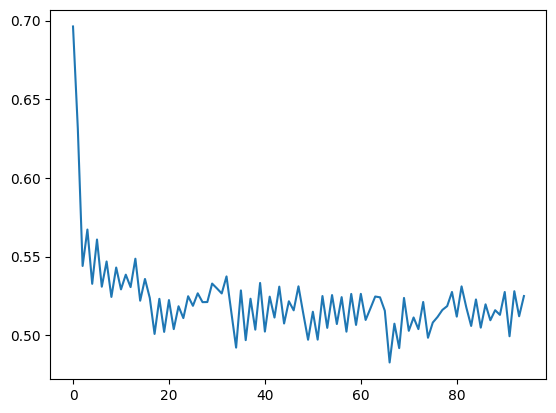

In [70]:
plt.plot(losses[::1000])

In [71]:
def get_embedding(query_token):
    index_token = vocab.token_to_idx([query_token])[0]
    with torch.no_grad():
        embed = net.embed_v.weight.data[index_token]
        print(f"Index token of {query_token}: ", index_token)
    return embed
def get_similar_token(query_token, k, include_score=False):
        embed = get_embedding(query_token)
        dot_prod =  torch.matmul(net.embed_v.weight.data ,
                                 embed) / (torch.sqrt(torch.sum(net.embed_v.weight.data**2,  dim=1),) *  torch.sqrt(torch.sum(embed**2)))
        index_token = vocab.token_to_idx([query_token])[0]
        dot_prod[index_token]= -torch.inf
        topk = torch.topk(dot_prod, k)
        top_indices = topk.indices.cpu().tolist()
        print(top_indices)
        words = vocab.idx_to_token(top_indices)
        if include_score:
            scores = topk.values
            return words, scores
        return words
    

get_similar_token('man', 10, True)
    

Index token of man:  167
[18010, 8401, 23939, 4444, 893, 19376, 7231, 24342, 11739, 19084]


(['vilified',
  'machinery',
  'lows',
  'favorable',
  'jews',
  'sweepstakes',
  'yugoslav',
  'self-sufficiency',
  'openness',
  'ants'],
 tensor([0.2686, 0.2447, 0.2328, 0.2311, 0.2271, 0.2247, 0.2146, 0.2139, 0.2121,
         0.2073], device='cuda:0'))

In [72]:
def words_distance(w1, w2):
    e1, e2 = get_embedding(w1), get_embedding(w2)
    
    dot = torch.dot(e1, e2) / (torch.sqrt(torch.sum(e1**2)) *  torch.sqrt(torch.sum(e2**2)))
    
    return dot
words_distance('man', 'woman'), 

Index token of man:  167
Index token of woman:  384


(tensor(0.1861, device='cuda:0'),)

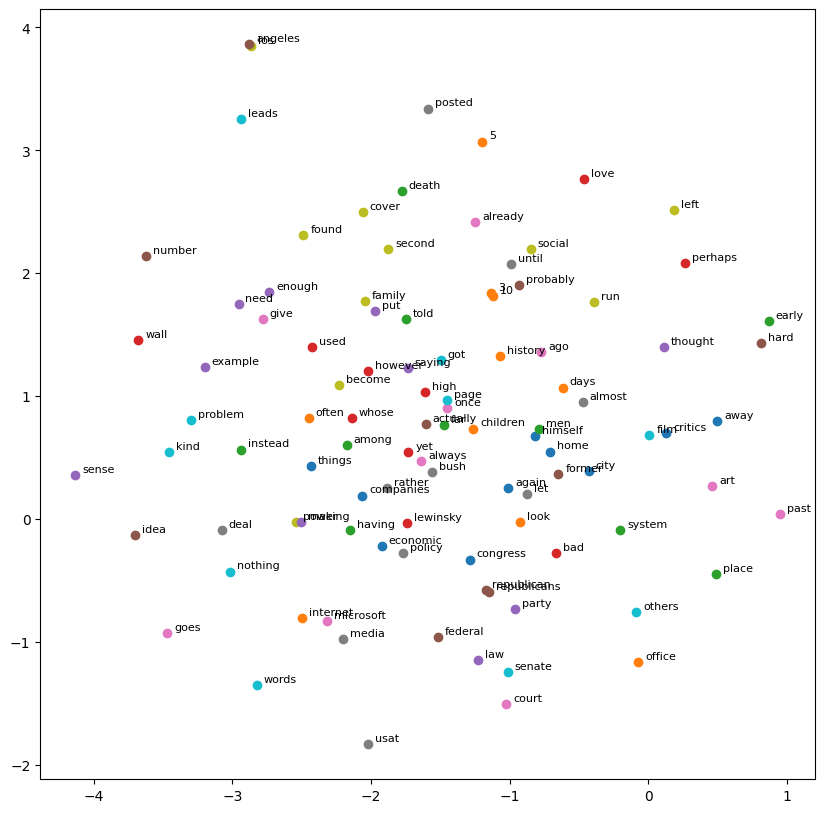

In [73]:
def plot_tsne():
    embeddings = net.embed_v.weight.data.cpu().numpy()[250:350]
    tsne = TSNE(n_components=2).fit_transform(embeddings)
    fig =  plt.figure(figsize=(10, 10))
    _df = vocab.voc_df.copy()
    _df = _df.sort_values(by=["idx"]).reset_index(drop=True)[250:350]
    for i, label in enumerate(_df['token']):
        x, y = tsne[i]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points", fontsize=8)
    plt.show()
plot_tsne()

In [74]:
get_similar_token("poor", 10, True)

Index token of poor:  605
[9602, 4282, 20921, 11717, 17941, 5080, 13978, 27861, 16535, 4007]


(['readership',
  'rolls',
  'inequity',
  'paparazzi',
  'retaliatory',
  'encounters',
  'alarmingly',
  'scientologist',
  'sox',
  'essays'],
 tensor([0.2390, 0.2301, 0.2261, 0.2246, 0.2238, 0.2229, 0.2227, 0.2213, 0.2190,
         0.2186], device='cuda:0'))

In [75]:
get_similar_token("small", 10, True)

Index token of small:  404
[544, 23126, 23071, 4861, 4588, 21375, 23554, 21874, 401, 7943]


(['large',
  'vintner',
  'deity',
  'leonard',
  'signals',
  'garlic',
  'slits',
  'transcendence',
  'set',
  'louisiana'],
 tensor([0.2925, 0.2479, 0.2331, 0.2313, 0.2307, 0.2271, 0.2209, 0.2201, 0.2198,
         0.2182], device='cuda:0'))

In [76]:
e1 = get_embedding('man')
e2 = get_embedding('woman')
d1 = get_embedding('good')

Index token of man:  167
Index token of woman:  384
Index token of good:  121


In [77]:
W = net.embed_v.weight.data

In [78]:
e = e1 - e2 + d1
dst = torch.matmul(W, e) # / (torch.norm(W, 2) * torch.norm(e))
topk = torch.topk(dst, 20)

In [79]:
vocab.idx_to_token([k for k in topk.indices.cpu().tolist()]), topk.values

(['frikik',
  'hipster',
  'sweepstakes',
  'malevolent',
  'florida',
  'announcement',
  'dictum',
  'jewel',
  'ably',
  'skulls',
  'phillips',
  'rapacious',
  'mistaking',
  'feeds',
  'ingrained',
  'hospitalized',
  'koch',
  'descriptive',
  'nature',
  'logevall'],
 tensor([26.1943, 25.0949, 24.2238, 23.9985, 23.7607, 23.1993, 22.9982, 22.5340,
         22.0786, 22.0722, 21.8094, 21.8015, 21.4114, 21.3108, 21.2377, 21.0165,
         20.9168, 20.9048, 20.7945, 20.6814], device='cuda:0'))